/home/yczhong/.conda/envs/jasper/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'TGN_GDELT_node_to_cnt.pt'

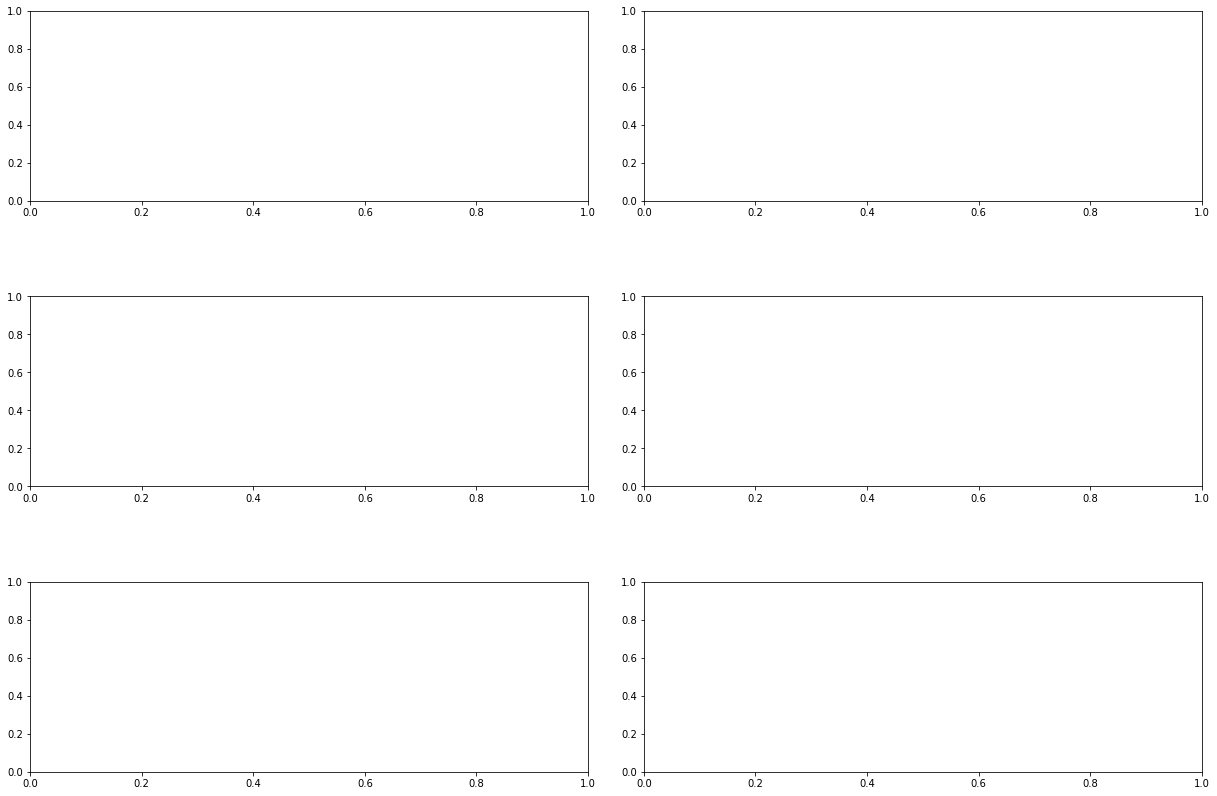

In [4]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.stats import expon
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import skew

import torch
import itertools

models = ['TGN', 'TGAT', 'GRAPHSAGE']
datasets = ['GDELT']


param_space = list(itertools.product(
    models, datasets))

nrow = len(param_space)
ncol = 2
fig, axes = plt.subplots(nrow, ncol, figsize=(nrow*7, ncol*7))
# set margin
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for idx, param in enumerate(param_space):
    node_to_cnt = torch.load("{}_{}_node_to_cnt.pt".format(*param))
    edge_to_cnt = torch.load("{}_{}_edge_to_cnt.pt".format(*param))

    def log_rank_freq(data, ax, type):
        values = data.cpu().numpy()
        values = values[values > 0]
        values = np.sort(values)[::-1]
        cutoff = np.percentile(values, 95)
        values = values[values > cutoff]
        ranks = range(1, len(values)+1)

        x = np.log10(ranks)
        y = np.log10(values)
        
        coeffs = np.polyfit(x, y, 1)
        alpha = coeffs[0]
        C = 10**coeffs[1]
        print(alpha, coeffs[1])

        ax.scatter(ranks, values, s=15)

        x = np.logspace(np.log10(ranks[0]), np.log10(ranks[-1]), num=len(ranks))
        y = C * x**(alpha) 
        ax.loglog(x, y, linestyle='--', color='r')
        ax.grid(axis='y')
        ax.set_xlabel("Node Log Rank")
        ax.set_ylabel("Log Occuerence")
        ax.set_title("Distribution of access parttern of nodes for training {} on {}".format(*param))

    def hist(data, ax, label, model):
        data = data.cpu().numpy()
        print(np.max(data))
        ax.hist(data, bins=1000, density=True)
        ax.set_xlabel('# {} Occuerence'.format(label))
        ax.set_ylabel('{} Frequency'.format(label))
        cutoff = np.percentile(data, 99.9)
        print(cutoff)
        ax.set_xlim((0, cutoff))
        ax.grid(axis='y')
        ax.set_title("Distribution of access parttern of edges for training {} on {}".format(*param))

        if model == "TGN":
            pass
        elif model  == "TGAT":
            loc, scale = expon.fit(data)
            pdf = expon.pdf(np.linspace(5, max(data), 1000), loc, scale)
            ax.plot(np.linspace(5, max(data), 1000), pdf, 'r--', linewidth=2)
            print("lambda = {:.4f}".format(1/scale))
        elif model == "GRAPHSAGE":
            skew_param = skewnorm.fit(data)
            pdf = skewnorm.pdf(np.linspace(0, cutoff, 100), *skew_param)

            ax.plot(np.linspace(0, cutoff ,100), pdf, 'r-', linewidth=2)
        

    log_rank_freq(node_to_cnt, axes[idx][0], 'Node')
    hist(edge_to_cnt, axes[idx][1], 'Edge', param[0])

plt.show()

In [3]:
import numpy as np

def calculate_stack_distance(sequence, max_distance):
    stack = {}
    total_distance = 0

    for ele in sequence:
        if ele in stack:
            distance = len(stack) - stack[ele]
        else:
            distance = max_distance

        stack[ele] = len(stack)
        total_distance += distance

    return total_distance / len(sequence)

In [4]:
arr = [1, 1, 2, 1, 1]

calculate_stack_distance(arr, np.unique(arr).shape[0])

1.2

In [5]:
import math
def compute_affinity(dist):
    return 1.0 / math.log10(10 + dist)

In [8]:
import itertools
import os
import torch

models = ['shuffle_TGAT']
datasets = ['WIKI', 'REDDIT', 'MOOC', 'LASTFM']

param_space = itertools.product(
    models, datasets)
sub_dir = "tmp_res/"

for param in param_space:
    node_sequence = torch.load(sub_dir+"{}_{}_node_sequence.pt".format(*param))
    edge_sequence = torch.load(sub_dir+"{}_{}_edge_sequence.pt".format(*param))
                               
    node_stack_distance = calculate_stack_distance(node_sequence.tolist(), np.unique(node_sequence).shape[0])
    edge_stack_distance = calculate_stack_distance(edge_sequence.tolist(), np.unique(edge_sequence).shape[0])

    node_temporal_affinity = compute_affinity(node_stack_distance) * 100 
    edge_temporal_affinity = compute_affinity(edge_stack_distance) * 100

    print("Temporal affinity for {} on {}: node {:.2f}%, edge {:.2f}%".format(
        *param, node_temporal_affinity, edge_temporal_affinity))


Temporal affinity for shuffle_TGAT on WIKI: node 89.58%, edge 33.53%
Temporal affinity for shuffle_TGAT on REDDIT: node 95.95%, edge 27.72%
Temporal affinity for shuffle_TGAT on MOOC: node 97.20%, edge 29.33%
Temporal affinity for shuffle_TGAT on LASTFM: node 99.93%, edge 25.66%


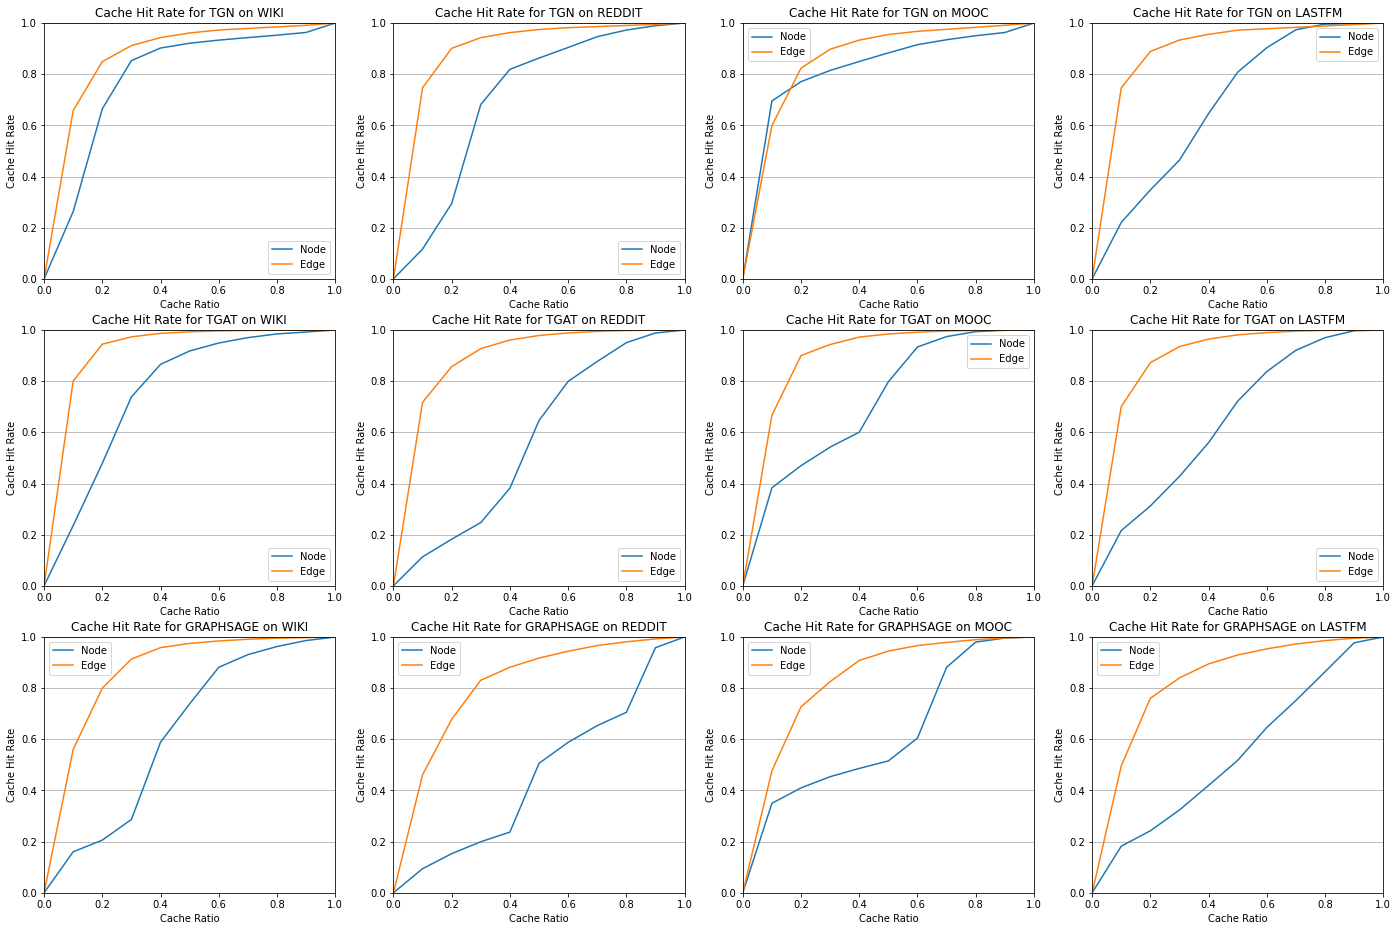

In [1]:
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt

models = ['TGN', 'TGAT', 'GRAPHSAGE', 'shuffle_GRAPHSAGE']
datasets = ['WIKI', 'REDDIT', 'MOOC', 'LASTFM']
cache_ratio = np.arange(0, 1.1, 0.1)

fig, axes = plt.subplots(len(models), len(datasets), figsize=(len(models)*8, len(datasets)*4))

param_space = itertools.product(
    models, datasets, cache_ratio)
sub_dir = "tmp_res/cache_hit_rate_10epochs/"
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        node_cache_hit_rate_list = []
        edge_cache_hit_rate_list = []
        for ratio in cache_ratio:
            node_cache_hit_rate_list.append(float(np.load(
                sub_dir+"cache_node_hit_ratio_{}_{}_LRUCache_{:.1f}.npy".format(model, dataset, ratio))))
            edge_cache_hit_rate_list.append(float(np.load(
                sub_dir+"cache_edge_hit_ratio_{}_{}_LRUCache_{:.1f}.npy".format(model, dataset, ratio))))

            # print("Cache hit rate for {} on {}: node {:.2f}%, edge {:.2f}%".format(
            #     model, dataset, node_cache_hit_rate_list[-1]*100, edge_cache_hit_rate_list[-1]*100))
        
        node_cache_hit_rate_list[-1] = 1
        edge_cache_hit_rate_list[-1] = 1
        axes[i][j].plot(cache_ratio, node_cache_hit_rate_list, label='Node')
        axes[i][j].plot(cache_ratio, edge_cache_hit_rate_list, label='Edge')
        axes[i][j].set_xlabel('Cache Ratio')
        axes[i][j].set_ylabel('Cache Hit Rate')
        axes[i][j].set_title('Cache Hit Rate for {} on {}'.format(model, dataset))
        axes[i][j].legend()
        axes[i][j].grid(axis='y')
        axes[i][j].set_xlim((0, 1))
        axes[i][j].set_ylim((0, 1))
        

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

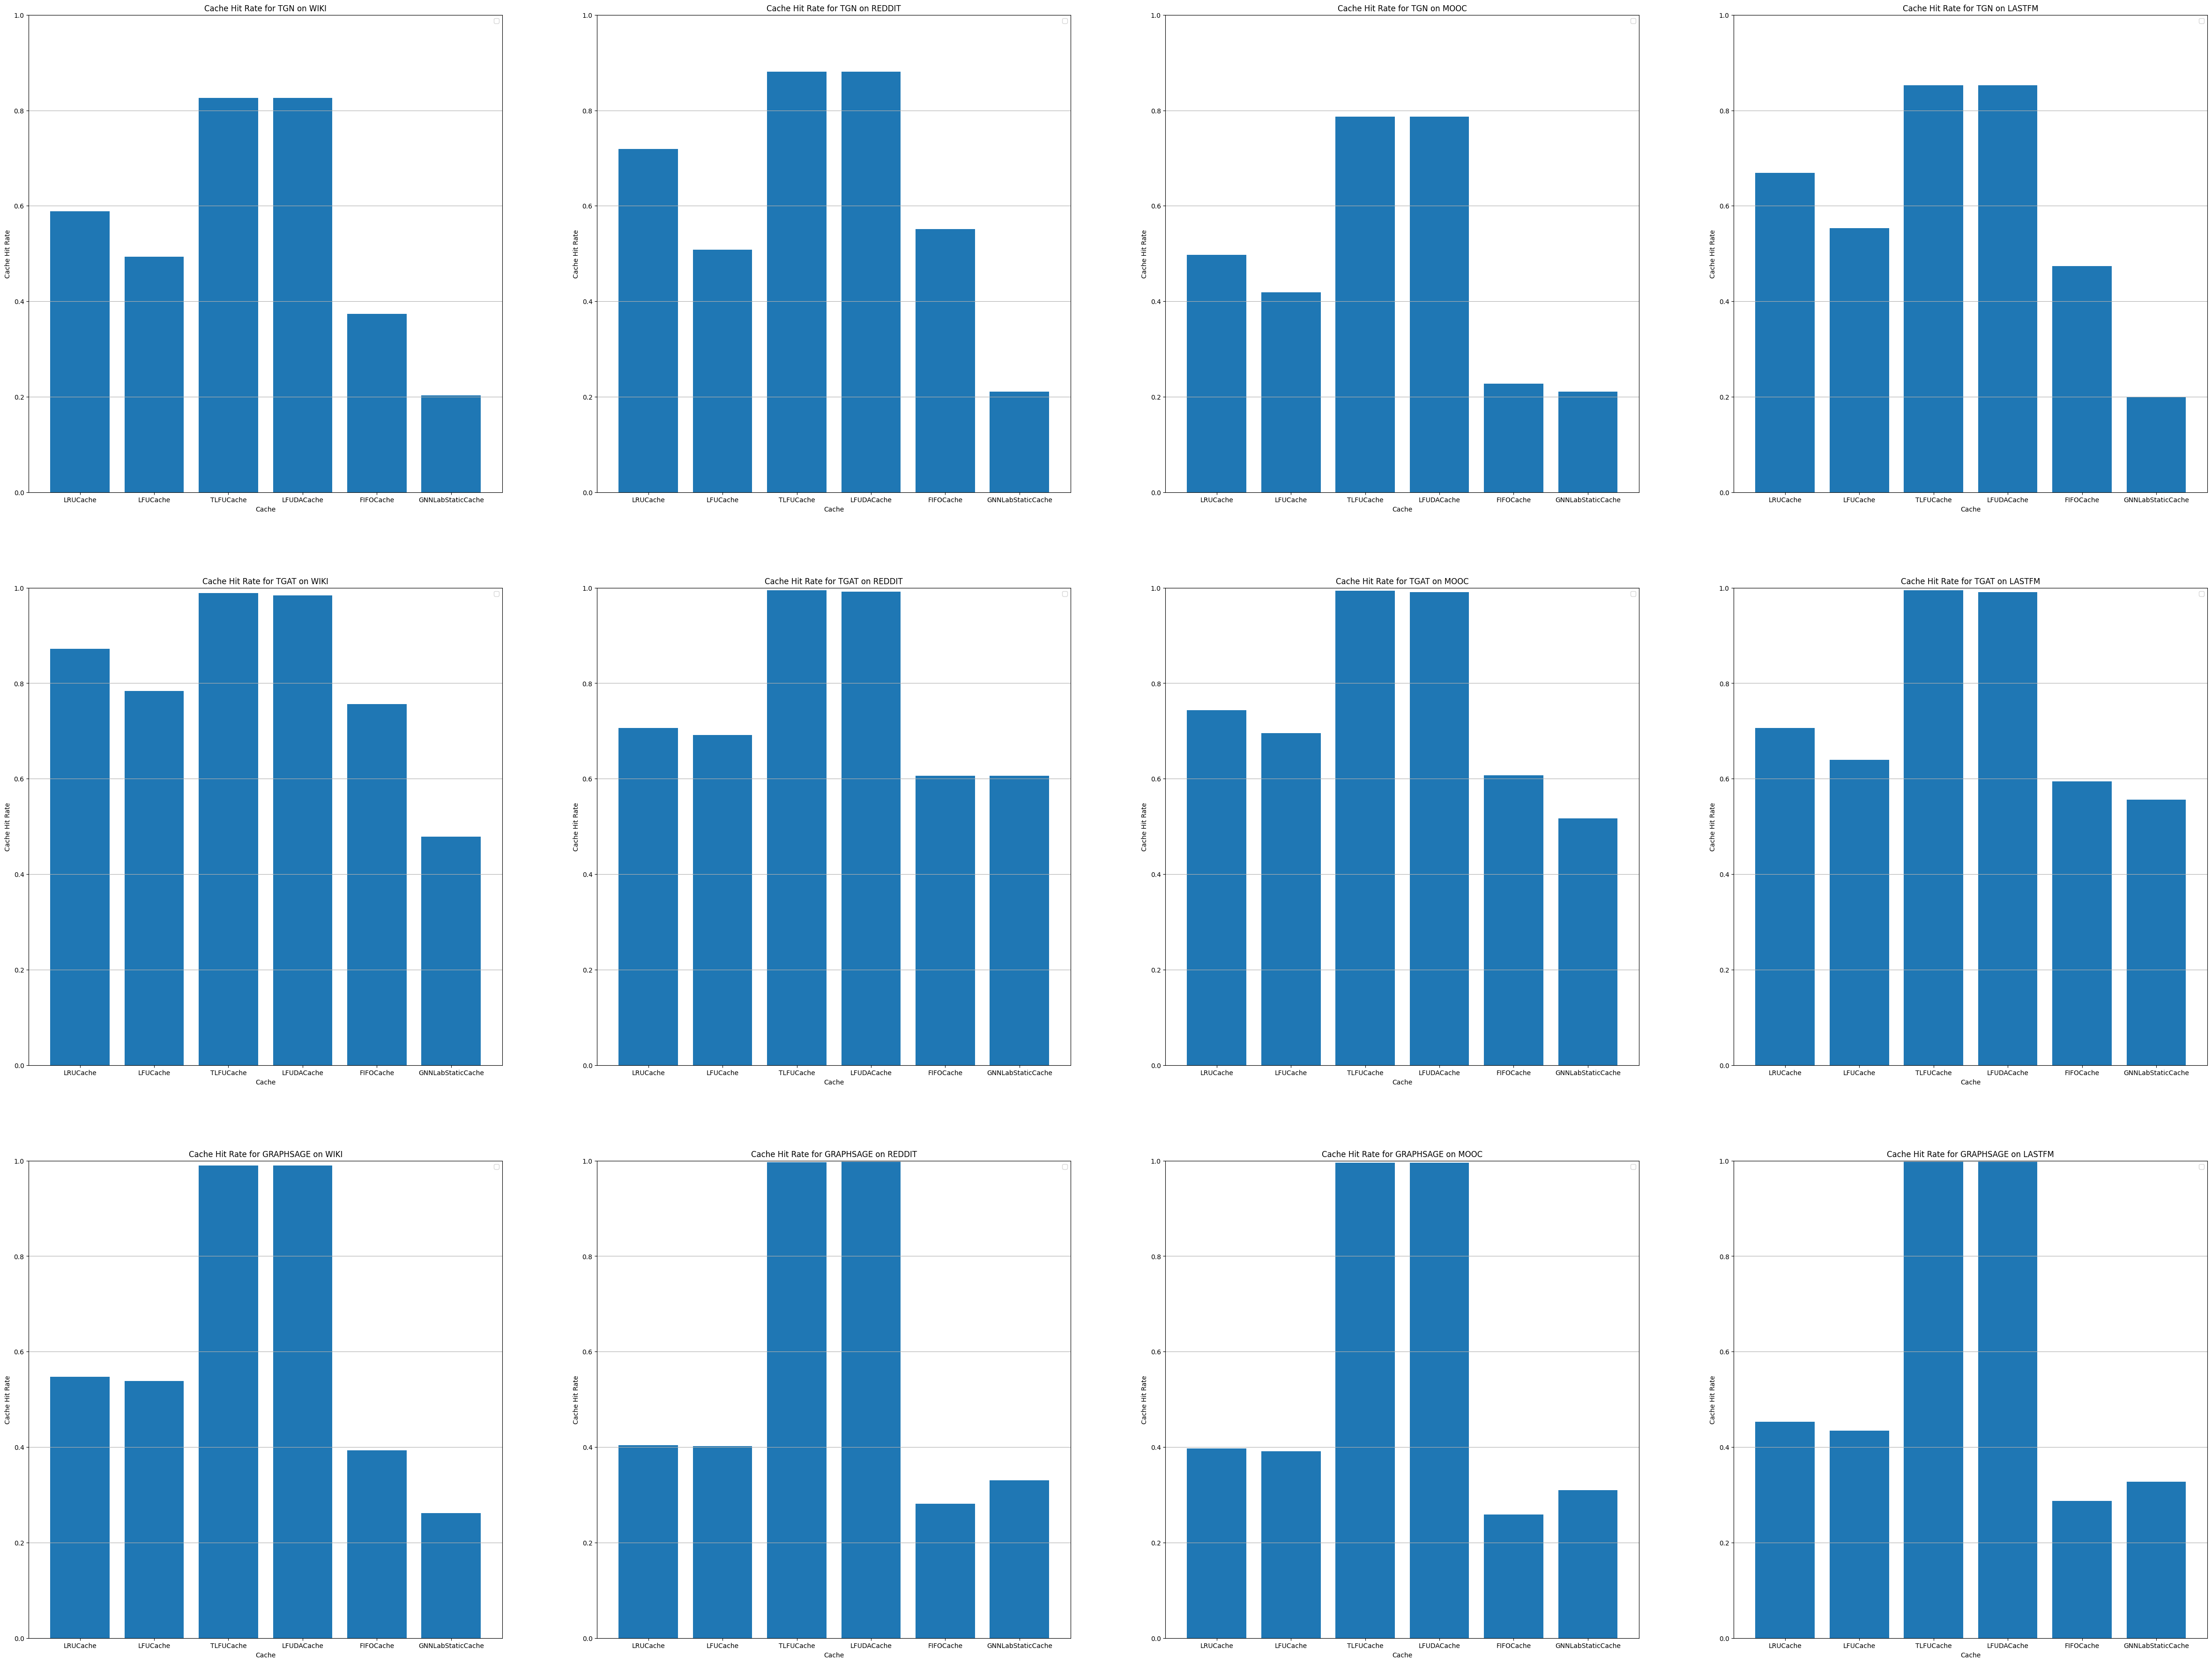

In [23]:
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt

models = ['TGN', 'TGAT', 'GRAPHSAGE']
datasets = ['WIKI', 'REDDIT', 'MOOC', 'LASTFM']
caches = ['LRUCache', 'LFUCache', 'TLFUCache', 'LFUDACache', 'FIFOCache', 'GNNLabStaticCache']

fig, axes = plt.subplots(len(models), len(datasets), figsize=(len(datasets)*15, len(models)*15), squeeze=False)

param_space = itertools.product(
    models, datasets, caches)
sub_dir = "tmp_res/cache_hit_rate_new/"
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        cache_hit_rate_list = []
        for cache in caches:
            cache_hit_rate_list.append(np.load(sub_dir + f"cache_edge_hit_ratio_{model}_{dataset}_{cache}_0.2.npy"))
            print("{} Cache hit rate for {} on {}: {}".format(cache, model, dataset, cache_hit_rate_list[-1]))
            
        axes[i][j].bar(caches, cache_hit_rate_list)
        axes[i][j].set_xlabel('Cache')
        axes[i][j].set_ylabel('Cache Hit Rate')
        axes[i][j].set_title('Cache Hit Rate for {} on {}'.format(model, dataset))
        axes[i][j].legend()
        axes[i][j].grid(axis='y')
        axes[i][j].set_ylim((0, 1))
        

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

LRUCache Cache hit rate for TGN on WIKI: 0.659492552280426
LFUCache Cache hit rate for TGN on WIKI: 0.6644072532653809
TLFUCache Cache hit rate for TGN on WIKI: 0.9586330056190491
LFUDACache Cache hit rate for TGN on WIKI: 0.9587286710739136
FIFOCache Cache hit rate for TGN on WIKI: 0.5963524580001831
GNNLabStaticCache Cache hit rate for TGN on WIKI: 0.698412299156189
LRUCache Cache hit rate for TGN on REDDIT: 0.2947431206703186
LFUCache Cache hit rate for TGN on REDDIT: 0.29401078820228577
TLFUCache Cache hit rate for TGN on REDDIT: 0.9905794262886047
LFUDACache Cache hit rate for TGN on REDDIT: 0.9908275604248047
FIFOCache Cache hit rate for TGN on REDDIT: 0.2944258749485016
GNNLabStaticCache Cache hit rate for TGN on REDDIT: 0.6549965143203735
LRUCache Cache hit rate for TGN on MOOC: 0.7723162174224854
LFUCache Cache hit rate for TGN on MOOC: 0.7447554469108582
TLFUCache Cache hit rate for TGN on MOOC: 0.9592859745025635
LFUDACache Cache hit rate for TGN on MOOC: 0.9594687819480896


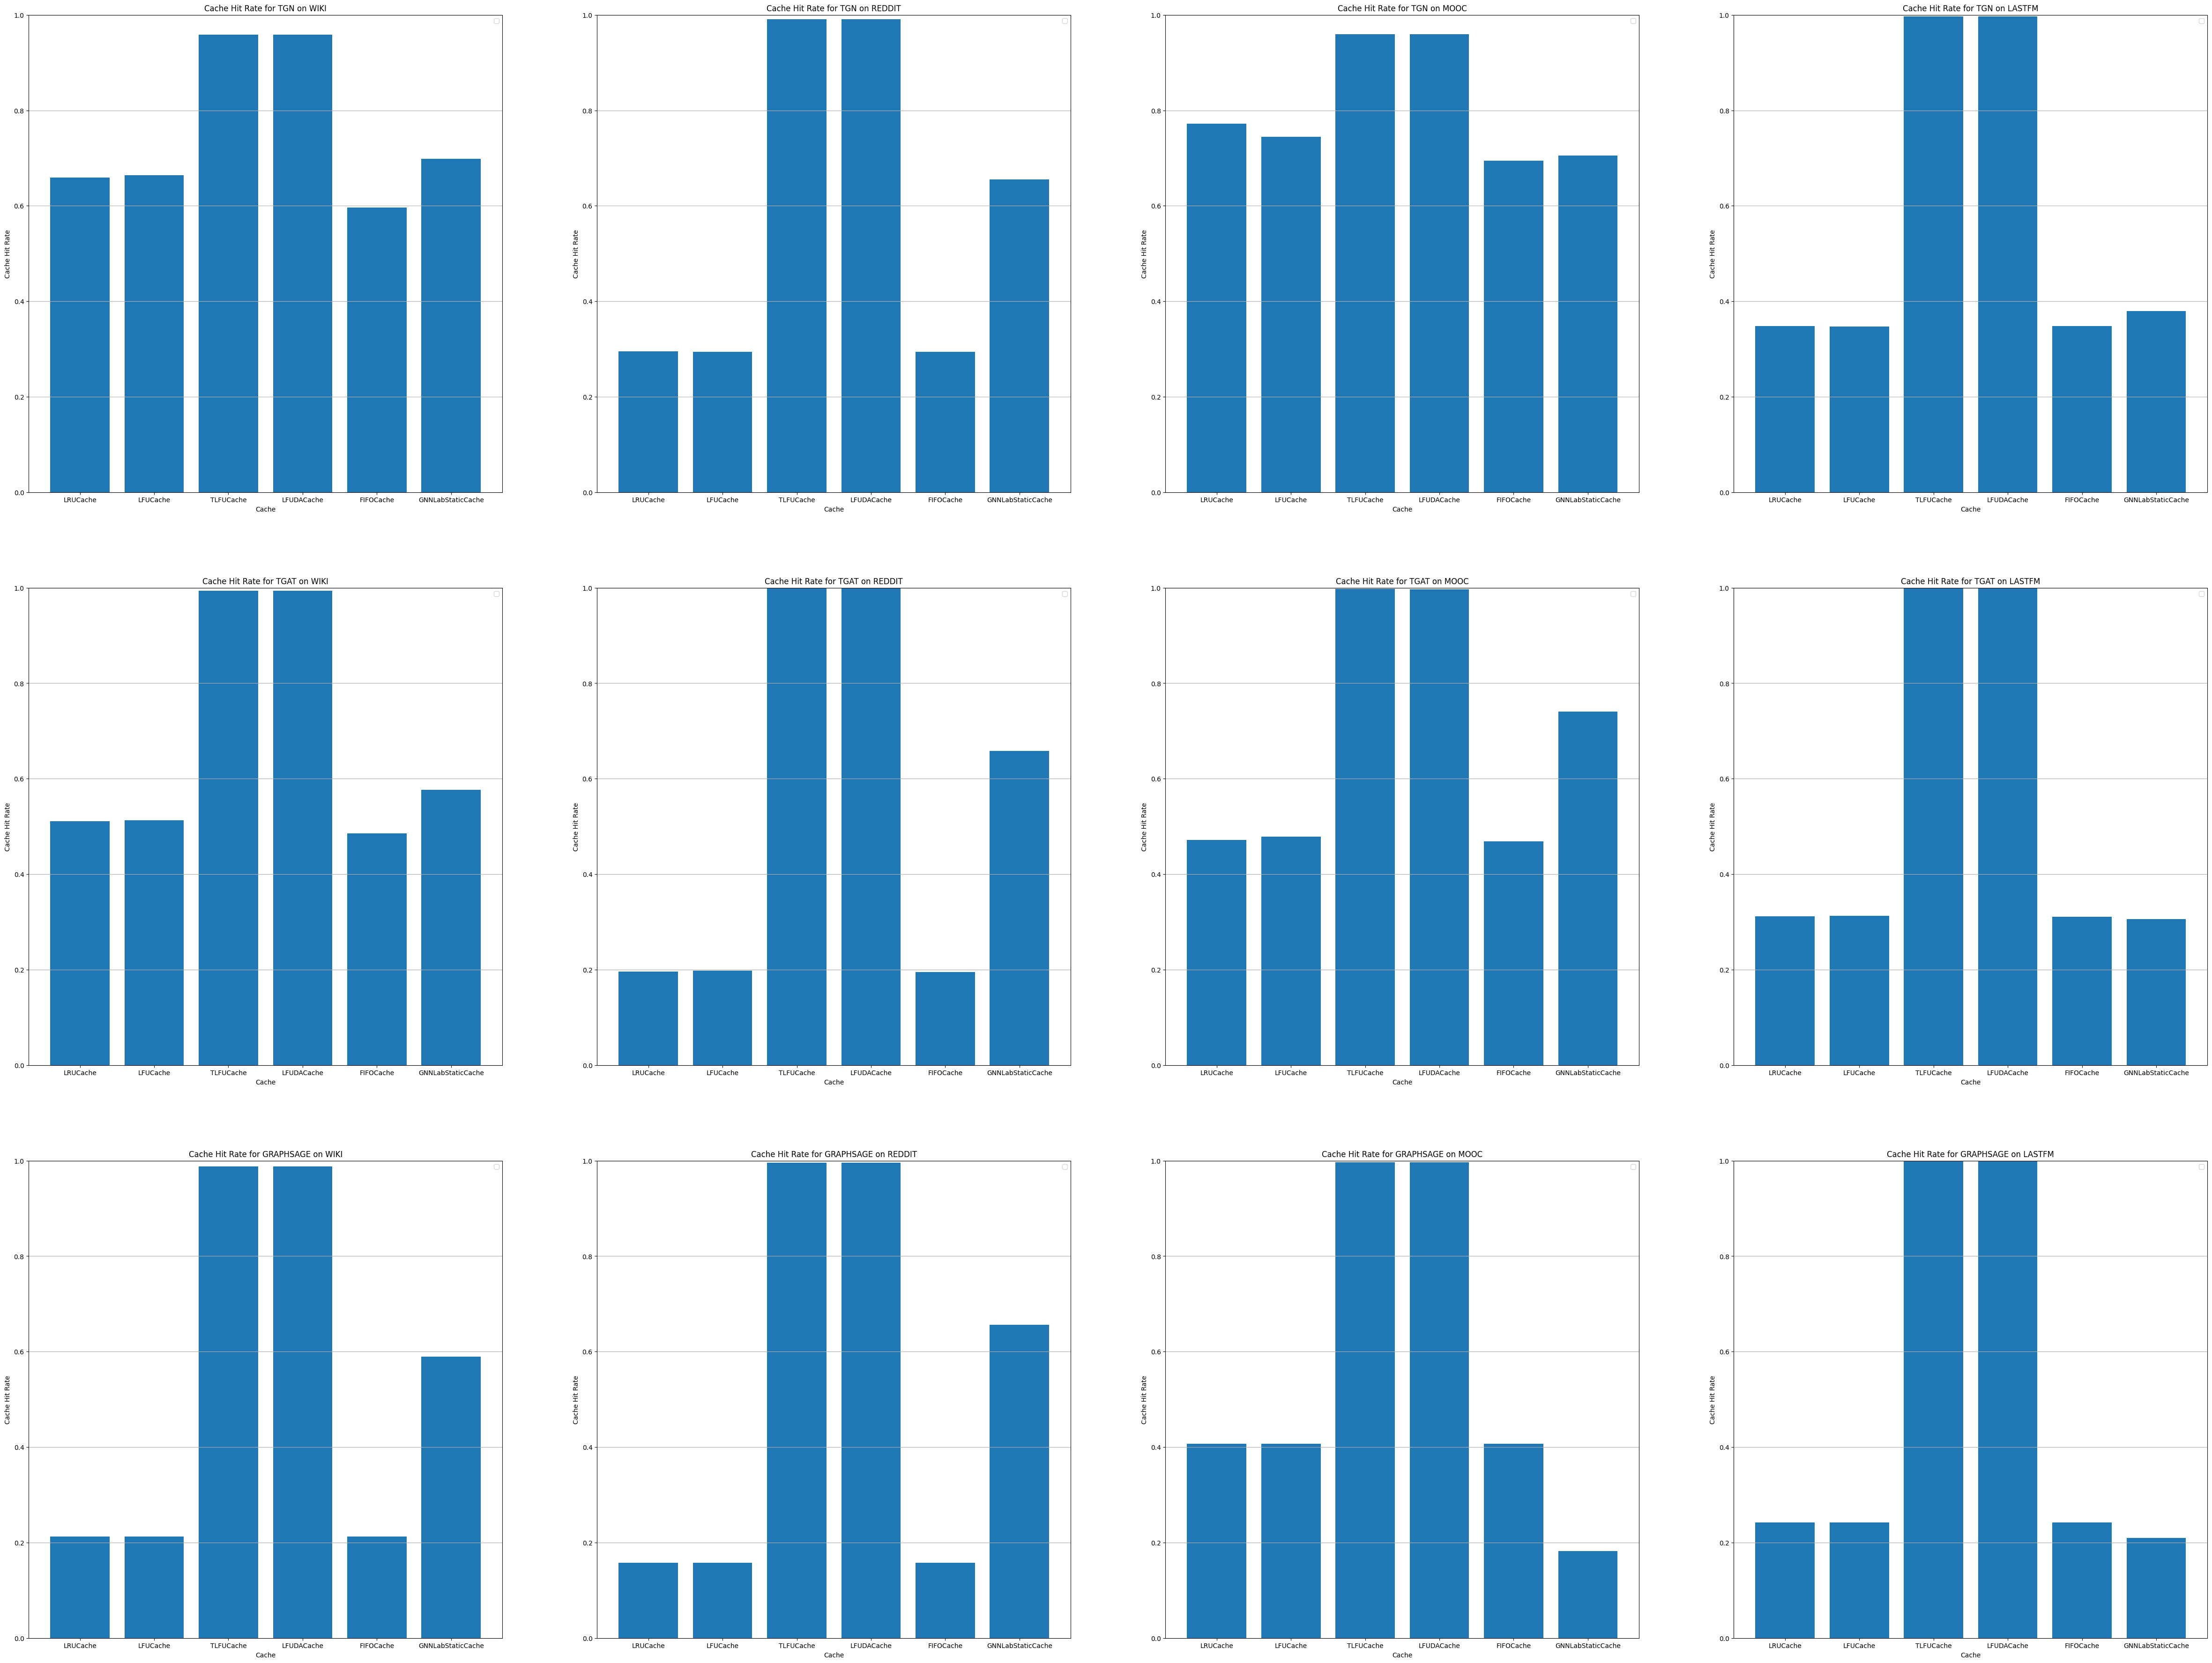

In [26]:
import itertools
import os
import numpy as np
import matplotlib.pyplot as plt

models = ['TGN', 'TGAT', 'GRAPHSAGE']
datasets = ['WIKI', 'REDDIT', 'MOOC', 'LASTFM']
caches = ['LRUCache', 'LFUCache', 'TLFUCache', 'LFUDACache', 'FIFOCache', 'GNNLabStaticCache']

fig, axes = plt.subplots(len(models), len(datasets), figsize=(len(datasets)*15, len(models)*15), squeeze=False)

param_space = itertools.product(
    models, datasets, caches)
sub_dir = "tmp_res/cache_hit_rate_new/"
for i, model in enumerate(models):
    for j, dataset in enumerate(datasets):
        cache_hit_rate_list = []
        for cache in caches:
            cache_hit_rate_list.append(np.load(sub_dir + f"cache_node_hit_ratio_{model}_{dataset}_{cache}_0.2.npy"))
            print("{} Cache hit rate for {} on {}: {}".format(cache, model, dataset, cache_hit_rate_list[-1]))
            
        axes[i][j].bar(caches, cache_hit_rate_list)
        axes[i][j].set_xlabel('Cache')
        axes[i][j].set_ylabel('Cache Hit Rate')
        axes[i][j].set_title('Cache Hit Rate for {} on {}'.format(model, dataset))
        axes[i][j].legend()
        axes[i][j].grid(axis='y')
        axes[i][j].set_ylim((0, 1))
        

plt.show()
